In [3]:
import sys
sys.path.insert(0, '../train')
from helper import *
%matplotlib inline

#Wireless Parameters
N_t = 64
N_r = 16
latent_dim = 65
channel_model = 'A'

length = int(N_t/4)
breadth = int(N_r/4)

G_test = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, 128*length*breadth),
    torch.nn.ReLU(),
    View([1,128,length,breadth]),
    torch.nn.Upsample(scale_factor=2),
    Conv2d(128,128,4,bias=False),
    torch.nn.BatchNorm2d(128,momentum=0.8),
    torch.nn.ReLU(),
    torch.nn.Upsample(scale_factor=2),
    Conv2d(128,128,4,bias=False),
    torch.nn.BatchNorm2d(128,momentum=0.8),
    torch.nn.ReLU(),
    Conv2d(128,2,4,bias=False),
)
G_test = G_test.type(dtype)

In [903]:
import copy
H_org = sio.loadmat("data/H_16x64_MIMO_CDL_%s_ULA_clean.mat"%channel_model)
H_ex = H_org['hest']
H_extracted = np.transpose(copy.deepcopy(H_ex),(2,1,0))
dft_basis = sio.loadmat("data/dft_basis.mat")
A_T = dft_basis['A1']/np.sqrt(N_t)
A_R = dft_basis['A2']/np.sqrt(N_r)
for i in range(H_ex.shape[2]):
    H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))

img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)

mu_real = np.mean(img_np_real,axis=0)
mu_imag = np.mean(img_np_imag,axis=0)
std_real = np.std(img_np_real,axis=0)
std_imag = np.std(img_np_imag,axis=0)

A_T_R = np.kron(A_T.conj(),A_R)
A_T_R_real = dtype(np.real(A_T_R))
A_T_R_imag = dtype(np.imag(A_T_R))

H_org = sio.loadmat("data/H_16x64_MIMO_CDL_%s_ULA_test.mat"%channel_model)
H_ex = H_org['hest']
H_extracted = np.transpose(copy.deepcopy(H_ex),(2,1,0))
for i in range(H_ex.shape[2]):
    H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))
img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)
img_np_real = (img_np_real - mu_real)/std_real
img_np_imag = (img_np_imag - mu_imag)/std_imag

In [914]:
N_s = N_r
N_rx_rf = N_r
Nbit_t = 6
Nbit_r = 2
angles_t = np.linspace(0,2*np.pi,2**Nbit_t,endpoint=False)
angles_r = np.linspace(0,2*np.pi,2**Nbit_r,endpoint=False)
hybrid = 1
freq = 2000
model_vec = range(0,61000,freq)

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_rx_rf):
    angle_index = np.random.choice(len(angles_r),(N_r,N_rx_rf))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

ntest = 20              
nrepeat = 5 #Different noise realizations
SNR_vec = range(15,20,5)
alpha = 0.4
nmse_CDL_A_amb_ld_65_snr_30_reset_optim_D = np.zeros((len(SNR_vec),len(model_vec)))
ct = 0
N_p = int(alpha*N_t)
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])

if hybrid:
    pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
    symbols = qpsk_constellation[pilot_sequence_ind]
    precoder_training = training_precoder(N_t,N_s)
    W = training_combiner(N_r,N_rx_rf)
    A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
else:
    pilot_sequence_ind = np.random.randint(0,4,size=(N_t,N_p))
    pilot_sequence = qpsk_constellation[pilot_sequence_ind]
    A = np.kron(np.matrix(pilot_sequence).getT(),identity)

A_real = dtype(np.real(A))
A_imag = dtype(np.imag(A))
identity = np.identity(N_r)
lambda_reg = 1e-3
iter_arr = np.array([10,40,80,100,110,120,130])
ct += 1
for model in model_vec:
    if model < 60000:
        G_test.load_state_dict(torch.load('../Final/checkpoints/AmbWGAN/CDL-A/ld_65/SNR_30/reset_optim_D/generator%d.pt'%model)) 
    else:
        G_test.load_state_dict(torch.load('../Final/checkpoints/AmbWGAN/CDL-A/ld_65/SNR_30/reset_optim_D/amb_generator_LS_CDL_ld_35_FFT.pt')) 
    G_test.eval()
    for SNR in SNR_vec:
        for i in range(nrepeat):
            for ind in range(ntest):
                vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
                if hybrid:
                    signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
                else:
                    signal = np.matmul(H_ex[:,:,ind],pilot_sequence)
                E_s = np.multiply(signal,np.conj(signal))
                noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
                vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
                std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
                rx_signal = signal + np.multiply(std_dev,noise_matrix)
                if hybrid:
                    rx_signal = np.matmul(W,rx_signal)
                vec_y[:,0,0] = rx_signal.flatten('F') 
                vec_y_real = dtype(np.real(vec_y[:,:,0]))
                vec_y_imag = dtype(np.imag(vec_y[:,:,0]))
                def gen_output(x):
                    pred = G_test(x)
                    pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                    pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                    pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                    pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                    diff_real = vec_y_real - torch.mm(A_real,pred_real) + torch.mm(A_imag,pred_imag)
                    diff_imag = vec_y_imag - torch.mm(A_real,pred_imag) - torch.mm(A_imag,pred_real)
                    diff = torch.norm(diff_real)**2 + torch.norm(diff_imag)**2
                    return diff + lambda_reg*torch.norm(x)**2
                x = Variable(torch.randn(1, latent_dim)).type(dtype)
                x.requires_grad = True
                learning_rate = 1e-1
                optimizer = torch.optim.Adam([x], lr=learning_rate)
                for a in range(100): 
                    optimizer.zero_grad()
                    loss = gen_output(x)
                    loss.backward()
                    optimizer.step()
                gen_imgs = G_test(x).data.cpu().numpy()
                gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
                gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
                gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
                gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
                nmse_CDL_A_amb_ld_65_snr_30_reset_optim_D[ct-1,int((model-model_vec[0])/freq)] = nmse_CDL_A_amb_ld_65_snr_30_reset_optim_D[ct-1,int((model-model_vec[0])/freq)] + (np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
                print((np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)
nmse_CDL_A_amb_ld_65_snr_30_reset_optim_D = nmse_CDL_A_amb_ld_65_snr_30_reset_optim_D/(ntest*nrepeat)

0.7376890252995374
0.7416220506780419
0.6341202691521425
0.49849011324432296
0.8113115094265962
0.680275585978844
0.838545051131363
0.8285741951438664
0.8338974325549635
0.9360175984452773
0.6412439619219917
0.7567037832362359
0.769660765749725
1.0438310576089969
0.6216896037836417
0.7331662578271746
0.9479762201591503
0.8712854245216587
0.6140018634883463
0.6195170065722708
0.6782765018228515
0.743432174185196
0.7048565854759765
0.49058415016166507
0.8071863845277027
0.5631678212986638
0.760776021898198
0.7049145300480402
0.8215313674634248
0.8086471519205255
0.5487465006711265
0.7631976035022406
0.7159470161508309
0.8100437152057002
0.5591977391987113
0.7023404905365019
0.9988441529032108
0.9668785297693421
0.6352290049107442
0.6524314522443817
0.7567247500476803
0.7507414040484175
0.633061833766464
0.5946240778547434
0.7796051313572016
0.6662364912501526
0.798954471226664
0.7825339025133575
0.8487462076932295
0.9364824112094011
0.5540981345820194
0.7584838977619385
0.638957808823072

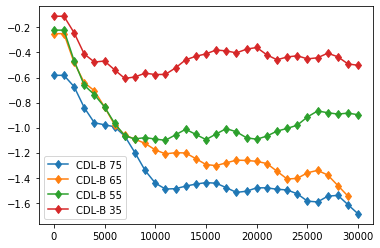

In [539]:
plt.plot(range(0,31000,1000),smooth(10*np.log10(nmse_CDL_B_ld_75).T[:,0],6),'d-',label='CDL-B 75')
plt.plot(range(0,30000,1000),smooth(10*np.log10(nmse_CDL_B_ld_65[:,:-1]/(ntest*nrepeat)).T[:,0],6),'d-',label='CDL-B 65')
plt.plot(range(0,31000,1000),smooth(10*np.log10(nmse_CDL_B_ld_55).T[:,0],6),'d-',label='CDL-B 55')
plt.plot(range(0,31000,1000),smooth(10*np.log10(nmse_CDL_B).T[:,0],6),'d-',label='CDL-B 35')
plt.legend()

In [ ]:
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_C_ld_55).T[:,0],6),'d-',label='CDL-C 55')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_C_ld_65).T[:,0],6),'d-',label='CDL-C 65')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_A_ld_55).T[:,0],6),'d-',label='CDL-A 55')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_D_ld_65).T[:,0],6),'d-',label='CDL-D 65')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_E_ld_65).T[:,0],6),'d-',label='CDL-E 65')
plt.plot(range(0,31000,1000),smooth(10*np.log10(nmse_CDL_B_ld_55).T[:,0],6),'d-',label='CDL-B 55')
plt.plot(range(0,61000,2000),10*np.log10(nmse_CDL_B_ld_65).T[:,0],'d-',label='CDL-B 65')
plt.plot(range(0,61000,2000),10*np.log10(nmse_CDL_B_ld_75).T[:,0],'d-',label='CDL-B 75')

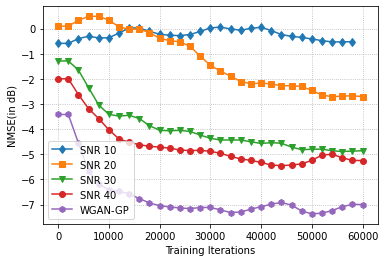

In [919]:
plt.plot(range(0,60000,2000),smooth(10*np.log10(nmse_CDL_A_amb_ld_65_snr_10[:,:-1]).T[:,0],6),'d-',label='SNR 10')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_A_amb_ld_65_snr_20).T[:,0],6),'s-',label='SNR 20')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_A_amb_ld_65_snr_30).T[:,0],6),'v-',label='SNR 30')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_A_amb_ld_65_snr_40).T[:,0],6),'o-',label='SNR 40')
plt.plot(range(0,61000,2000),smooth(10*np.log10(nmse_CDL_A_ld_65).T[:,0],6),'h-',label='WGAN-GP')
plt.legend(loc='lower left')
plt.ylabel('NMSE(in dB)')
plt.xlabel('Training Iterations')
plt.grid(ls=':')
plt.savefig('../Final/results/AmbWGAN_CDL_A_LD_65.pdf',dpi=10000)

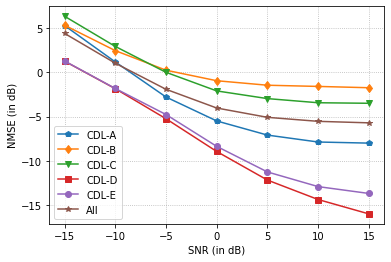

In [901]:
nmse_SNR_WGAN_GP_ld_65_reset_optim_D = np.concatenate([nmse_SNR_CDL_A_ld_65_reset_optim_D.T,nmse_SNR_CDL_B_ld_65_reset_optim_D.T,nmse_SNR_CDL_C_ld_65_reset_optim_D.T,nmse_SNR_CDL_D_ld_65_reset_optim_D.T,nmse_SNR_CDL_E_ld_65_reset_optim_D.T],axis=0)
np.save('../Final/results/NMSE_SNR_WGAN_GP_ld_65_reset_optim_D.npy',nmse_SNR_WGAN_GP_ld_65_reset_optim_D)
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_A_ld_65_reset_optim_D),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_B_ld_65_reset_optim_D),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_C_ld_65_reset_optim_D),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_D_ld_65_reset_optim_D),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_E_ld_65_reset_optim_D),'o-',label='CDL-E')
plt.plot(SNR_vec,10*np.log10(np.mean(nmse_SNR_WGAN_GP_ld_65_reset_optim_D,axis=0)),'*-',label='All')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')
plt.savefig('../Final/results/NMSE SNR WGAN GP LD 65 Reset Optim D.pdf',dpi=5000)

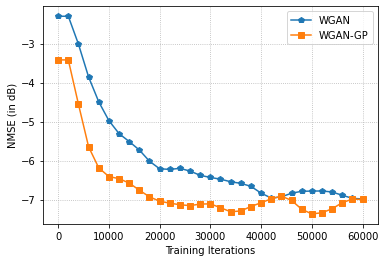

In [885]:
model_vec = range(0,61000,2000)
nmse_WGAN = np.array([0.97929806, 0.57661647, 0.62391689, 0.541986  , 0.52370313,
       0.49663636, 0.49858248, 0.46804209, 0.44941764, 0.44056783,
       0.41686779, 0.43035293, 0.369758  , 0.39311537, 0.37091193,
       0.3884127 , 0.36554285, 0.36246113, 0.37864907, 0.40614421,
       0.42552836, 0.39566115, 0.43175012, 0.42728023, 0.41619991,
       0.38576607, 0.40959335, 0.38884405, 0.39450068, 0.3855968])
#plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_A_ld_65_no_GP.T)[:,0],6),'d-',label='WGAN')
#plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_A_ld_65.T)[:,0],6),'v-',label='WGAN-GP')
plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_A_ld_65_no_GP_reset_optim_D.T)[:,0],6),'p-',label='WGAN')
plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_A_ld_65_reset_optim_D.T)[:,0],6),'s-',label='WGAN-GP')
plt.grid(ls=':')
plt.xlabel('Training Iterations')
plt.ylabel('NMSE (in dB)')
plt.legend(loc='upper right')
plt.savefig('../Final/results/NMSE Training Iterations CDL A WGAN vs WGAN-GP LD 65 Reset Optim D.pdf',dpi=5000)

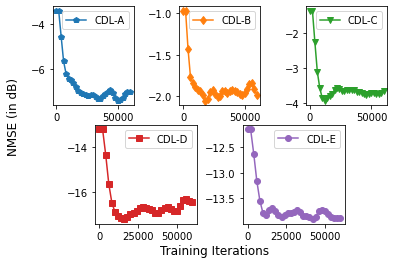

In [890]:
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(2,16), loc=(0,0), colspan=4)
ax2 = plt.subplot2grid((2,16), (0,6), colspan=4)
ax3 = plt.subplot2grid((2,16), (0,12), colspan=4)
ax4 = plt.subplot2grid((2,16), (1,2), colspan=5)
ax5 = plt.subplot2grid((2,16), (1,9), colspan=5)
ax1.plot(model_vec,smooth(10*np.log10(nmse_CDL_A_ld_65_reset_optim_D).T[:,0],6),'p-',label='CDL-A',color='#1f77b4')
ax2.plot(model_vec,smooth(10*np.log10(nmse_CDL_B_ld_65_reset_optim_D).T[:,0],6),'d-',label='CDL-B',color='#ff7f0e')
ax3.plot(model_vec,smooth(10*np.log10(nmse_CDL_C_ld_65_reset_optim_D).T[:,0],6),'v-',label='CDL-C',color='#2ca02c')
ax4.plot(model_vec,smooth(10*np.log10(nmse_CDL_D_ld_65_reset_optim_D).T[:,0],6),'s-',label='CDL-D',color='#d62728')
ax5.plot(model_vec,smooth(10*np.log10(nmse_CDL_E_ld_65_reset_optim_D).T[:,0],6),'o-',label='CDL-E',color='#9467bd')
ax1.legend(loc='upper right'); ax2.legend(loc='upper right'); ax3.legend(loc='upper right'); 
fig.supylabel('NMSE (in dB)')
fig.supxlabel('Training Iterations')
ax4.legend(loc='upper right'); ax5.legend(loc='upper right'); 
plt.savefig('../Final/results/NMSE Training Iterations WGAN-GP LD 65 Reset Optimizer D.pdf',dpi=10000)
np.savez('../Final/results/nmse_iter_WGAN_GP_ld_65_reset_optim_d.npz',nmse_CDL_A_ld_65,nmse_CDL_B_ld_65,nmse_CDL_C_ld_65,nmse_CDL_D_ld_65,nmse_CDL_E_ld_65)

In [891]:
print(np.argmin(nmse_CDL_A_ld_65_reset_optim_D),np.argmin(nmse_CDL_B_ld_65_reset_optim_D),np.argmin(nmse_CDL_C_ld_65_reset_optim_D),np.argmin(nmse_CDL_D_ld_65_reset_optim_D),np.argmin(nmse_CDL_E_ld_65_reset_optim_D))

25 9 5 7 18


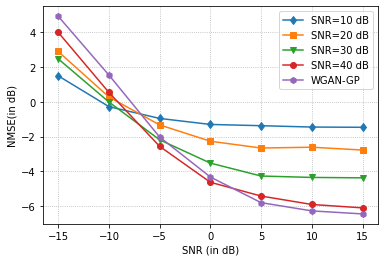

In [739]:
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_A_amb_10_ld_65),'d-',label='SNR=10 dB')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_A_amb_20_ld_65),'s-',label='SNR=20 dB')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_A_amb_30_ld_65),'v-',label='SNR=30 dB')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_A_amb_40_ld_65),'o-',label='SNR=40 dB')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_CDL_A_ld_65),'h-',label='WGAN-GP')
plt.legend()
plt.ylabel('NMSE(in dB)')
plt.xlabel('SNR (in dB)')
plt.grid(ls=':')
plt.savefig('../Final/results/AmbWGAN_CDL_A_SNR_ld_65.pdf',dpi=5000)

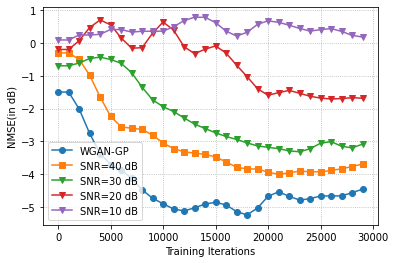

In [330]:
plt.plot(model_vec[:-1],smooth(nmse_wgan_gp.T,6),'o-',label='WGAN-GP')
plt.plot(model_vec[:-1],smooth(10*np.log10(np.roll(nmse_CDL_A_amb_40,9)).T[:,0],6),'s-',label='SNR=40 dB')
plt.plot(model_vec[:-1],smooth(10*np.log10(nmse_CDL_A_amb_30).T[:,0],6),'v-',label='SNR=30 dB')
plt.plot(model_vec[:-1],smooth(10*np.log10(nmse_CDL_A_amb_20).T[:,0],6),'v-',label='SNR=20 dB')
plt.plot(model_vec[:-1],smooth(10*np.log10(nmse_CDL_A_amb_10).T[:,0],6),'v-',label='SNR=10 dB')
plt.legend()
plt.ylabel('NMSE(in dB)')
plt.xlabel('Training Iterations')
plt.grid(ls=':')
plt.savefig('../Final/results/AmbWGAN_CDL_A.pdf',dpi=5000)

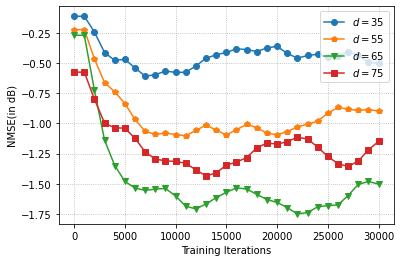

In [761]:
model_vec = range(0,31000,1000)
plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_B[0,:]),6),'o-',label=r'$d=35$')
plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_B_ld_55[0,:]),6),'p-',label=r'$d=55$')
plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_B_ld_65[0,0:31]),6),'v-',label=r'$d=65$')
plt.plot(model_vec,smooth(10*np.log10(nmse_CDL_B_ld_75[0,0:31]),6),'s-',label=r'$d=75$')
plt.legend(loc='upper right')
plt.ylabel('NMSE(in dB)')
plt.xlabel('Training Iterations')
plt.grid(ls=':')
plt.savefig('../Final/results/NMSE_Training_Iter_CDL_B_d.pdf',dpi=10000)

In [477]:
print(np.argmin(np.roll(nmse_CDL_A_amb_40,9)),np.argmin(nmse_CDL_A_amb_30),np.argmin(nmse_CDL_A_amb_20),np.argmin(nmse_CDL_A_amb_10))

20 23 28 0


In [325]:
def smooth(x,window_len=4,window='hanning'):
    if window_len<3:
        return x
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(window_len/2)-1):-int(window_len/2)]

In [907]:
Nbit_r = 2
angles_r = np.linspace(0,2*np.pi,2**Nbit_r,endpoint=False)
Nbit_t = 6
angles_t = np.linspace(0,2*np.pi,2**Nbit_t,endpoint=False)
hybrid = 1
ntest = 20              
nrepeat = 5 #Different noise realizations
SNR_vec = range(15,20,5)
alpha = 0.25
N_rx_rf = N_r
N_p = int(alpha*N_t)
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])
identity = np.identity(N_r)
lambda_reg = 1e-3
A_R_T = np.kron(np.transpose(A_T),np.matrix(A_R).getH())

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_rx_rf):
    angle_index = np.random.choice(len(angles_r),(N_r,N_rx_rf))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

N_s_arr = np.array([1,2,3,4,6,8,10,12,14,16])
nmse_CDL_25 = np.zeros((len(N_s_arr),1))
mse_top_16_real_25 = np.zeros((len(N_s_arr),16,2),dtype='complex64')
mse_bottom_16_real_25 = np.zeros((len(N_s_arr),16,2),dtype='complex64')
mse_top_16_est_25 = np.zeros((len(N_s_arr),16,2),dtype='complex64')
mse_bottom_16_est_25 = np.zeros((len(N_s_arr),16,2),dtype='complex64')

G_test.load_state_dict(torch.load('../Final/checkpoints/WGAN/CDL-A/ld_65/reset_optim_D/generator50000.pt')) 

ct = 0
for N_s in N_s_arr:
    ct += 1
    for ind in range(ntest):
        vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
        H_v = np.matmul(A_R_T,vec_H_single)
        indices = np.array((-np.abs(H_v)).argsort(axis=0)[:16]).flatten()
        indices_b = np.array((np.abs(H_v)).argsort(axis=0)[:16]).flatten()
        mse_top_16_real_25[ct-1,:,0:1] += nrepeat*H_v[indices,0]
        mse_bottom_16_real_25[ct-1,:,0:1] += nrepeat*H_v[indices_b,0]
        for i in range(nrepeat):
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
            for SNR in SNR_vec:
                if hybrid:
                    pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
                    symbols = qpsk_constellation[pilot_sequence_ind]
                    precoder_training = training_precoder(N_t,N_s)
                    W = training_combiner(N_r,N_s)
                    A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
                else:
                    pilot_sequence_ind = np.random.randint(0,4,size=(N_t,N_p))
                    pilot_sequence = qpsk_constellation[pilot_sequence_ind]
                    A = np.kron(np.matrix(pilot_sequence).getT(),identity)

                A_real = dtype(np.real(A))
                A_imag = dtype(np.imag(A))
                if hybrid:
                    signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
                else:
                    signal = np.matmul(H_ex[:,:,ind],pilot_sequence)
                E_s = np.multiply(signal,np.conj(signal))
                vec_y = np.zeros((N_s*N_p,1,1),dtype='complex64')
                std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
                rx_signal = signal + np.multiply(std_dev,noise_matrix)
                if hybrid:
                    rx_signal = np.matmul(W,rx_signal)
                vec_y[:,0,0] = rx_signal.flatten('F') 
                vec_y_real = dtype(np.real(vec_y[:,:,0]))
                vec_y_imag = dtype(np.imag(vec_y[:,:,0]))
                def gen_output(x):
                    pred = G_test(x)
                    pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                    pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                    pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                    pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                    diff_real = vec_y_real - torch.mm(A_real,pred_real) + torch.mm(A_imag,pred_imag)
                    diff_imag = vec_y_imag - torch.mm(A_real,pred_imag) - torch.mm(A_imag,pred_real)
                    diff = torch.norm(diff_real)**2 + torch.norm(diff_imag)**2
                    return diff + lambda_reg*torch.norm(x)**2
                x = Variable(torch.randn(1, latent_dim)).type(dtype)
                x.requires_grad = True
                learning_rate = 1e-1
                optimizer = torch.optim.Adam([x], lr=learning_rate)
                for a in range(100):
                    optimizer.zero_grad()
                    loss = gen_output(x)
                    loss.backward()
                    optimizer.step()
                gen_imgs = G_test(x).data.cpu().numpy()
                gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
                gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
                gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
                
                #Compute MSE metrics
                gen_imgs_complex_rs = np.reshape(gen_imgs_complex,[N_t*N_r,1])
                indices_est = np.array((-np.abs(gen_imgs_complex_rs)).argsort(axis=0)[:16]).flatten()
                indices_est_b = np.array((np.abs(gen_imgs_complex_rs)).argsort(axis=0)[:16]).flatten()
                mse_top_16_real_25[ct-1,:,1:2] += gen_imgs_complex_rs[indices]
                mse_top_16_est_25[ct-1,:,1:2] += gen_imgs_complex_rs[indices_est]
                mse_top_16_est_25[ct-1,:,0:1] += H_v[indices_est]
                mse_bottom_16_real_25[ct-1,:,1:2] += gen_imgs_complex_rs[indices_b]
                mse_bottom_16_est_25[ct-1,:,1:2] += gen_imgs_complex_rs[indices_est_b]
                mse_bottom_16_est_25[ct-1,:,0:1] += H_v[indices_est_b]
                
                gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
                nmse_CDL_25[ct-1] = nmse_CDL_25[ct-1] + (np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
                print((np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)
nmse_CDL_25 = nmse_CDL_25/(ntest*nrepeat)
mse_top_16_est_25 = mse_top_16_est_25/(ntest*nrepeat)
mse_top_16_real_25 = mse_top_16_real_25/(ntest*nrepeat)
mse_bottom_16_est_25 = mse_bottom_16_est_25/(ntest*nrepeat)
mse_bottom_16_real_25 = mse_bottom_16_real_25/(ntest*nrepeat)

1.6445730448402913
0.9553697154765143
1.4881844326308875
0.9984711094342763
1.245994086387159
1.1605534530499846
1.636827497987214
1.7529314291990814
1.6184376182069737
1.7277311729876796
1.4345610191807854
1.674678606017154
1.9282976763759476
1.4978905002196652
0.971925845289961
0.8527297661775716
0.9383772279266158
1.13543132402642
1.1604805226177062
0.7031727206789606
1.1780402664057101
1.0821053194927557
2.730674937564697
2.826142189598919
2.4344769676866456
0.9871903827155337
1.1694006522408795
1.105818888249899
1.3243435621295139
1.0684253778481447
1.2904049046371422
1.0136730015137265
1.185964364256479
1.0400163288627406
1.8253974922574365
1.5829135432445183
2.7059647980022685
1.8498960188275713
1.420782486967293
1.2731028507643227
1.5708825163483138
1.3224367779239432
1.2005506844916285
1.4654156834445717
1.4373997473451776
1.7228135586522653
1.4441084522469192
1.1817684212871944
2.0671087922288076
1.5984635868550177
1.0916585664289558
1.5482358984557094
1.06982154903823
1.4561

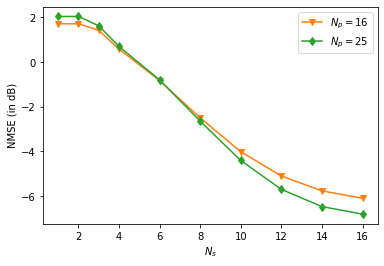

In [909]:
plt.plot(N_s_arr,smooth(10*np.log10(nmse_CDL_25)[:,0],6),'v-',label=r'$N_p=16$',color='#ff7f0e')
plt.plot(N_s_arr,smooth(10*np.log10(nmse_CDL_40)[:,0],6),'d-',label=r'$N_p=25$',color='#2ca02c')
plt.xlabel(r'$N_s$')
plt.ylabel('NMSE (in dB)')
plt.legend()
plt.savefig('../Final/results/NMSE_N_s_reset_optim_D.pdf',dpi=5000)